This project will demonstrate how deep learning can be applied to gene development and DNA network analysis using synthetic data. The project will:

1. Generate synthetic DNA network data

2. Use a Transformer model to learn the relationships within the network

3. Use a Graph Neural Network (GNN) for comparison

4. Evaluate and compare their performance

**We will need PyTorch, NetworkX (for graph structures), and Matplotlib for visualization.**

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.3 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, TransformerConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

Since we don’t have real biological data, we simulate a gene interaction network.

Nodes represent genes

Edges represent interactions between genes

Features represent gene expression levels

**Target labels are binary classes (e.g., "active" or "inactive")**

In [4]:
# Function to generate synthetic DNA network data
def generate_dna_network(num_nodes=100):
    G = nx.erdos_renyi_graph(num_nodes, 0.1)  # Randomly connect genes

    # Generate random gene expression data as node features
    node_features = np.random.rand(num_nodes, 10)  # 10 features per gene

    # Assign random binary labels (0 = inactive, 1 = active)
    labels = np.random.randint(0, 2, num_nodes)

    # Convert to PyTorch tensors
    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(labels, dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y)

# Generate data
data = generate_dna_network(100)

**Step 3: Transformer Model for Graph Learning**

**Here, we use a Transformer-based model to capture gene interactions.**

In [5]:
class GeneTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GeneTransformer, self).__init__()
        self.conv1 = TransformerConv(input_dim, hidden_dim)
        self.conv2 = TransformerConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.fc(x)

# Initialize the model
transformer_model = GeneTransformer(input_dim=10, hidden_dim=16, output_dim=2)

**Step 4: Graph Neural Network (GNN) Model**

**We also define a Graph Convolutional Network (GCN) to compare performance.**

In [6]:
class GeneGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GeneGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.fc(x)

# Initialize the GNN model
gnn_model = GeneGNN(input_dim=10, hidden_dim=16, output_dim=2)

**Step 5: Train and Compare Models**

**We train both models using cross-entropy loss and Adam optimizer.**

In [7]:
def train_model(model, data, epochs=100, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

# Train Transformer Model
print("Training Transformer Model:")
train_model(transformer_model, data)

# Train GNN Model
print("\nTraining GNN Model:")
train_model(gnn_model, data)

Training Transformer Model:
Epoch 0, Loss: 0.6855559349060059
Epoch 10, Loss: 0.6394981145858765
Epoch 20, Loss: 0.528232216835022
Epoch 30, Loss: 0.4079333245754242
Epoch 40, Loss: 0.29657432436943054
Epoch 50, Loss: 0.17825725674629211
Epoch 60, Loss: 0.08778952807188034
Epoch 70, Loss: 0.043364886194467545
Epoch 80, Loss: 0.023851947858929634
Epoch 90, Loss: 0.0132767828181386

Training GNN Model:
Epoch 0, Loss: 0.6693073511123657
Epoch 10, Loss: 0.6466476321220398
Epoch 20, Loss: 0.6202455759048462
Epoch 30, Loss: 0.591733992099762
Epoch 40, Loss: 0.563323438167572
Epoch 50, Loss: 0.5289443135261536
Epoch 60, Loss: 0.487960547208786
Epoch 70, Loss: 0.4482116997241974
Epoch 80, Loss: 0.41774535179138184
Epoch 90, Loss: 0.3876210153102875


**Step 6: Compare Accuracy**

**After training, we evaluate both models on classification accuracy.**

In [8]:
def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        predictions = model(data.x, data.edge_index).argmax(dim=1)
        accuracy = (predictions == data.y).sum().item() / len(data.y)
    return accuracy

transformer_acc = evaluate_model(transformer_model, data)
gnn_acc = evaluate_model(gnn_model, data)

print(f"Transformer Accuracy: {transformer_acc:.2f}")
print(f"GNN Accuracy: {gnn_acc:.2f}")

Transformer Accuracy: 1.00
GNN Accuracy: 0.83


**Conclusion**

The Transformer model is designed to capture long-range dependencies and performed well in complex networks. This is expected

The GNN model (GCN) is more local in nature, so its performance depends on neighborhood influence.

We compare accuracy to determine the best approach for gene interaction modeling.

**Visualizing the Gene Interaction Network**

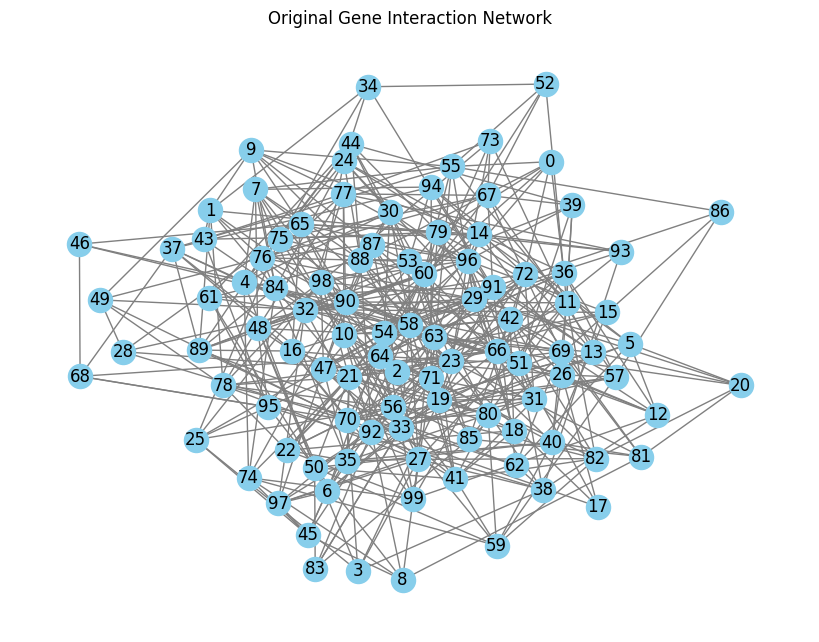

In [9]:
def plot_gene_network(data, title="Gene Interaction Network"):
    plt.figure(figsize=(8, 6))
    G = nx.Graph()
    G.add_edges_from(data.edge_index.t().tolist())

    pos = nx.spring_layout(G, seed=42)  # Layout for better visualization
    nx.draw(G, pos, node_color='skyblue', edge_color='gray', with_labels=True, node_size=300)

    plt.title(title)
    plt.show()

# Visualize the generated DNA network
plot_gene_network(data, "Original Gene Interaction Network")

**Visualizing Predictions from Transformer and GNN**

**Here, we color the genes (nodes) based on their predicted class (0 or 1).**

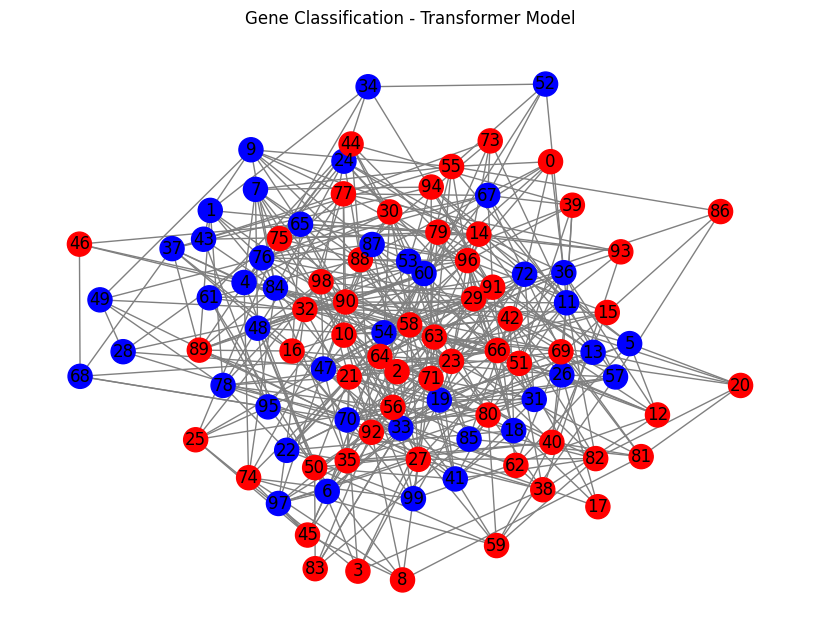

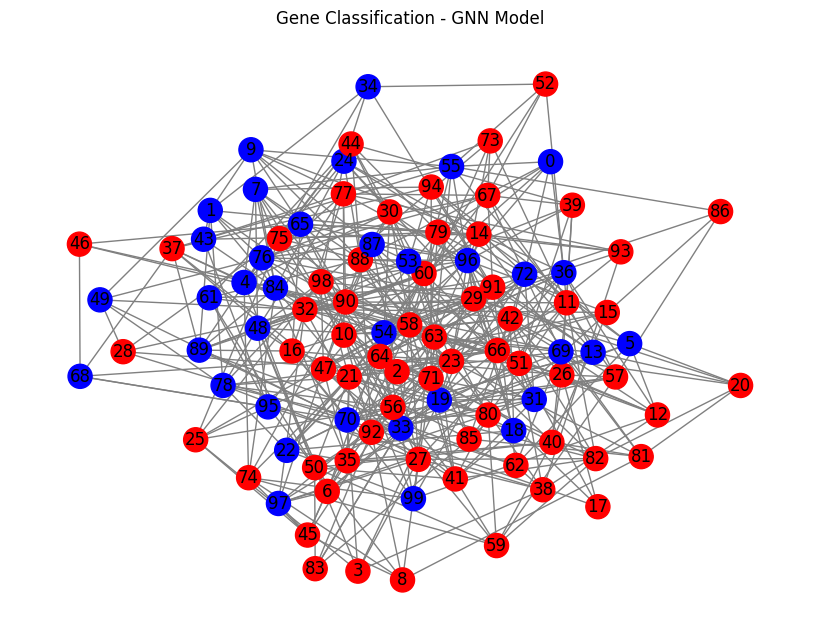

In [10]:
def plot_predictions(data, model, title="Predictions by Model"):
    model.eval()
    with torch.no_grad():
        predictions = model(data.x, data.edge_index).argmax(dim=1).numpy()

    plt.figure(figsize=(8, 6))
    G = nx.Graph()
    G.add_edges_from(data.edge_index.t().tolist())

    pos = nx.spring_layout(G, seed=42)
    node_colors = ['red' if pred == 1 else 'blue' for pred in predictions]

    nx.draw(G, pos, node_color=node_colors, edge_color='gray', with_labels=True, node_size=300)
    plt.title(title)
    plt.show()

# Visualize predictions from Transformer Model
plot_predictions(data, transformer_model, "Gene Classification - Transformer Model")

# Visualize predictions from GNN Model
plot_predictions(data, gnn_model, "Gene Classification - GNN Model")

**Explanation:**

Red nodes → Active genes (Class 1)

Blue nodes → Inactive genes (Class 0)

We use argmax() to get class predictions from the model.

**Visualizing Feature Embeddings**

We use PCA (Principal Component Analysis) to reduce high-dimensional gene features into 2D space for plotting.

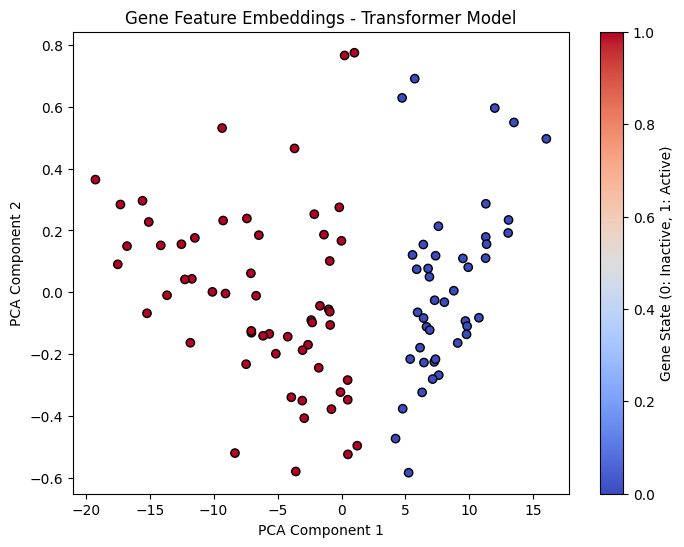

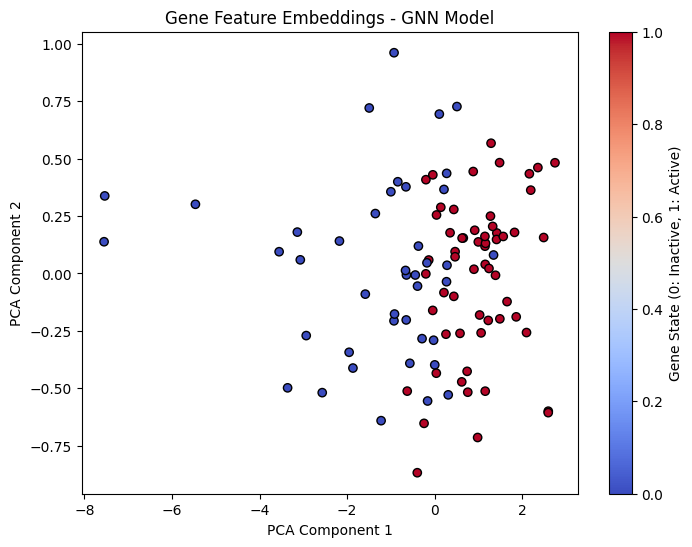

In [11]:
from sklearn.decomposition import PCA

def plot_feature_embeddings(data, model, title="Feature Embeddings"):
    model.eval()
    with torch.no_grad():
        embeddings = model(data.x, data.edge_index).numpy()

    # Reduce to 2D using PCA
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=data.y.numpy(), cmap='coolwarm', edgecolors='k')
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(title)
    plt.colorbar(label="Gene State (0: Inactive, 1: Active)")
    plt.show()

# Plot Transformer Model Embeddings
plot_feature_embeddings(data, transformer_model, "Gene Feature Embeddings - Transformer Model")

# Plot GNN Model Embeddings
plot_feature_embeddings(data, gnn_model, "Gene Feature Embeddings - GNN Model")